In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
import json
import folium
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

%matplotlib inline 

In [2]:
# 시각화 모듈 install
# pip install mapboxgl 

# font 지정
plt.rcParams['font.family'] = 'Malgun Gothic'


In [3]:
# 서울시 포털사이트에서 가져온 자료를 data화
population = pd.read_table('인구.txt',encoding='utf-8')
del population['기간']
del population['합계.1']
del population['합계.2']
del population['합계']
del population['세대']
del population['외국인']
del population['외국인.1']
del population['외국인.2']
del population['한국인.1']
del population['한국인.2']

population = pd.pivot_table(population, index = '자치구', aggfunc = np.sum)
new_pop = population.drop(['자치구','서울시'])
new_pop.rename(columns = {'한국인':'인구'}, inplace=True)
new_pop

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


,인구
자치구,
강남구,"537,879"
강동구,"464,208"
강북구,"306,639"
강서구,"579,082"
관악구,"493,374"
광진구,"345,248"
구로구,"402,642"
금천구,"231,290"
노원구,"520,366"


In [4]:
# 질병 및 스트레스 지수 data화
health = pd.read_csv('질병.csv', encoding='cp949')

health.rename(columns = {'지역(구)':'자치구','정신건강(스트레스 인지율)':'스트레스 인지율'}, inplace = True)
health = pd.pivot_table(health, index = ['자치구'])
health_per= new_pop.join(health)
del health_per['증등도 이상 신체활동 실천율']
del health_per['현재흡연율']

health_per.head()

,인구,걷기실천율,고혈압유병율,비만율,스트레스 인지율,월간음주율
자치구,,,,,,
강남구,"537,879",56.9,11.0,28.6,28.6,62.1
강동구,"464,208",52.8,15.3,31.3,21.6,56.7
강북구,"306,639",55.5,17.0,30.3,24.5,57.0
강서구,"579,082",56.5,12.3,30.7,29.1,57.9
관악구,"493,374",61.3,14.6,35.1,27.2,58.2


In [5]:
# 서울시 구별 면적과 공원면적
data = pd.read_csv('공원면적.txt', sep = "\t", engine='python', encoding = "utf-8")

data = data.drop(['Unnamed: 0','기간', 'Unnamed: 5', '조성면적(㎡)', '미조성면적(㎡)'], axis=1)
data.rename(columns={'구분':'자치구','공원면적(㎡)':'공원총면적(㎡)'}, inplace=True)
data = data[['자치구','행정구역면적(㎡)', '공원총면적(㎡)']]
data = pd.pivot_table(data, index = ['자치구'], aggfunc=np.sum)
report = health_per.join(data)

# 면적과 공원면적으로 구별 공원비율과 일인당 공원 면적 계산

# 1000단위마다 있는 " , " 제거
report['인구'] = report['인구'].apply(lambda x : x.replace(',',''))
report['공원총면적(㎡)'] = report['공원총면적(㎡)'].apply(lambda x : x.replace(',',''))
report['행정구역면적(㎡)'] = report['행정구역면적(㎡)'].apply(lambda x : x.replace(',',''))

# 속성 통일
report['인구'] = report['인구'].astype('float64')
report['공원총면적(㎡)'] = report['공원총면적(㎡)'].astype('float64')
report['행정구역면적(㎡)'] = report['행정구역면적(㎡)'].astype('float64')

 # 공원율(행정구역면적대비)= 공원면적/행정구역 면적*100  (round 함수로 소수점 지정)
report['공원비율'] = round((report['공원총면적(㎡)'] / report['행정구역면적(㎡)'])*100, 2)
report['1인공원면적(㎡)'] = round((report['공원총면적(㎡)'] / report['인구']), 2)
report['1인공원면적(㎡)'] = report['1인공원면적(㎡)'].astype('float64')

report.head()

,인구,걷기실천율,고혈압유병율,비만율,스트레스 인지율,월간음주율,공원총면적(㎡),행정구역면적(㎡),공원비율,1인공원면적(㎡)
자치구,,,,,,,,,,
강남구,537879.0,56.9,11.0,28.6,28.6,62.1,6594334.0,39501013.0,16.69,12.26
강동구,464208.0,52.8,15.3,31.3,21.6,56.7,3369773.0,24590256.0,13.70,7.26
강북구,306639.0,55.5,17.0,30.3,24.5,57.0,14342272.0,23600102.0,60.77,46.77
강서구,579082.0,56.5,12.3,30.7,29.1,57.9,4370320.0,41436853.0,10.55,7.55
관악구,493374.0,61.3,14.6,35.1,27.2,58.2,10976868.0,29568929.0,37.12,22.25


In [6]:
# 원본 data 보존 -> copy
report_score = report.copy()


def reRange(x, oldMin, oldMax, newMin, newMax):
    return (x - oldMin)*(newMax - newMin) / (oldMax - oldMin) + newMin 

# copy data 전체 점수화
col = report_score.columns
for i in col:
    report_score[i] = round(reRange((report_score[i]),min(report_score[i]), max(report_score[i]), 1, 10),2)

# 질병, 스트레스값을 반전 (질병율이 높을수록 점수가 낮게)
report_score['고혈압유병율'] = ((10 - report_score['고혈압유병율'])+1)
report_score['비만율'] = ((10 - report_score['비만율'])+1)
report_score['스트레스 인지율'] = ((10 - report_score['스트레스 인지율'])+1)
report_score['월간음주율'] = ((10 - report_score['월간음주율'])+1)


# 각 비율점수들의 총합과 순위 추가
report_point = report_score[[ '걷기실천율', '고혈압유병율', '비만율', '스트레스 인지율', 
                             '월간음주율', '공원비율']].astype('float64')

report_score['총합'] = report_point.sum(axis=1) 
report_score['순위'] = report_score['총합'].rank(method='min', ascending = False).astype('int64')
report_score = report_score.sort_values(ascending=False, by = '총합')

report_score

,인구,걷기실천율,고혈압유병율,비만율,스트레스 인지율,월간음주율,공원총면적(㎡),행정구역면적(㎡),공원비율,1인공원면적(㎡),총합,순위
자치구,,,,,,,,,,,,
용산구,2.75,8.93,5.43,8.90,10.00,8.76,1.31,3.89,1.00,1.49,43.02,1
서초구,5.98,4.50,6.87,10.00,3.36,8.42,10.00,10.00,5.46,5.17,38.61,2
동작구,5.41,7.97,4.91,6.17,5.88,8.49,3.01,2.55,4.40,1.98,37.82,3
중구,1.00,7.47,2.83,6.87,6.05,9.18,2.14,1.00,5.03,3.62,37.43,4
송파구,10.00,10.00,8.70,7.81,5.66,1.00,3.05,6.81,1.95,1.40,35.12,5
강북구,4.03,4.33,2.17,5.93,4.68,7.39,8.94,4.32,10.00,6.24,34.50,6
은평구,6.88,7.27,3.09,3.82,3.03,9.31,8.73,5.80,7.66,4.11,34.18,7
노원구,7.58,6.93,1.00,2.49,6.82,10.00,8.94,7.19,6.53,3.90,33.77,8
강남구,7.88,4.80,10.00,7.26,2.43,3.89,4.23,8.18,2.46,2.04,30.84,9


In [7]:
report_score.describe()

,인구,걷기실천율,고혈압유병율,비만율,스트레스 인지율,월간음주율,공원총면적(㎡),행정구역면적(㎡),공원비율,1인공원면적(㎡),총합,순위
count,25.000000,25.000000,25.00000,25.000000,25.0000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,5.346400,5.832000,4.92760,4.707200,4.0712,6.463200,4.169200,4.463600,4.114000,2.828400,30.115200,13.000000
std,2.129984,2.133944,2.09319,2.486474,1.9469,2.175993,2.766479,2.263347,2.471927,2.010173,5.619942,7.359801
min,1.000000,1.000000,1.00000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,17.360000,1.000000
25%,4.100000,4.500000,3.48000,2.800000,2.7600,5.400000,2.140000,2.810000,2.440000,1.520000,26.910000,7.000000
50%,5.410000,5.900000,4.91000,4.290000,3.7400,6.770000,3.010000,4.320000,2.980000,2.000000,28.920000,13.000000
75%,6.650000,6.930000,5.43000,6.870000,4.6800,7.600000,6.350000,5.770000,5.460000,3.620000,34.180000,19.000000
max,10.000000,10.000000,10.00000,10.000000,10.0000,10.000000,10.000000,10.000000,10.000000,10.000000,43.020000,25.000000


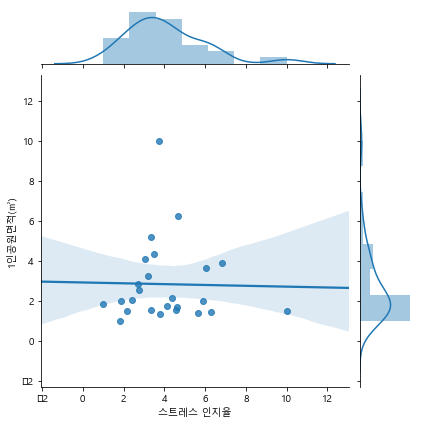

In [9]:
sns.jointplot(x="스트레스 인지율", y="1인공원면적(㎡)", data=report_score, kind='reg')

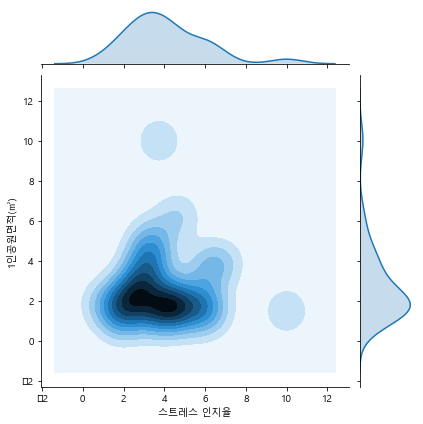

In [12]:
sns.jointplot(x="스트레스 인지율", y="1인공원면적(㎡)", data=report_score, kind='kde')

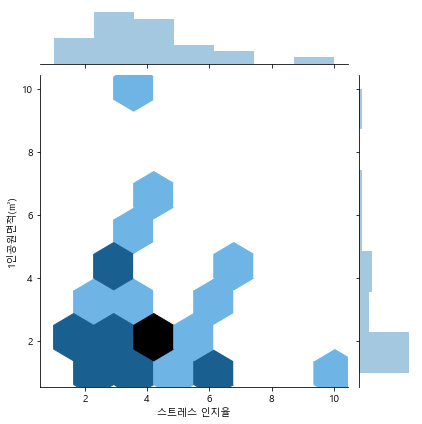

In [13]:
sns.jointplot(x="스트레스 인지율", y="1인공원면적(㎡)", data=report_score, kind='hex')

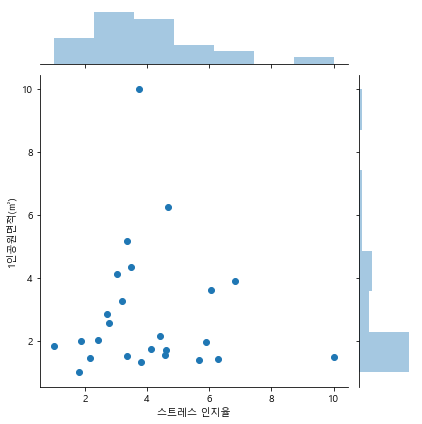

In [14]:
sns.jointplot(x="스트레스 인지율", y="1인공원면적(㎡)", data=report_score, kind='scatter')

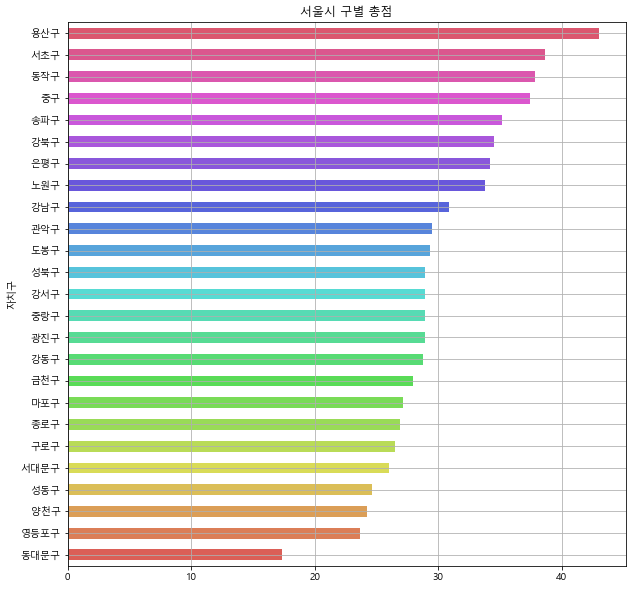

In [15]:
# 총점을 기준으로 막대그래프 시각화
colors=sns.color_palette('hls', len(report_score.index)) 

report_score['총합'].sort_values().plot(kind='barh',title="서울시 구별 총점", grid=True, figsize=(10,10), color=colors)

plt.show()


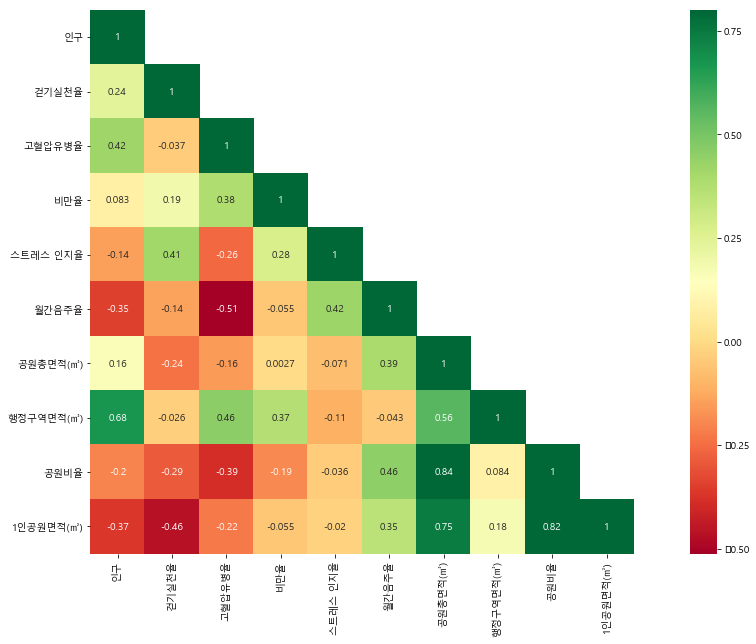

In [161]:
# 각 종목들의 상관관계
corrMatt = report_score[['인구', '걷기실천율', '고혈압유병율', '비만율', '스트레스 인지율', '월간음주율', '공원총면적(㎡)',
       '행정구역면적(㎡)', '공원비율', '1인공원면적(㎡)']]
corrMatt = corrMatt.corr()

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True,annot=True, cmap='RdYlGn')
# plt.rcParams['font.family'] = 'Malgun Gothic'


In [16]:
# 질병과 스트레스/ 공원비율의 상관관계 

result1 = stats.pearsonr(report_score['스트레스 인지율'], report_score['고혈압유병율']) #0.03
result2 = stats.pearsonr(report_score['스트레스 인지율'], report_score['비만율']) #0.04
result3 = stats.pearsonr(report_score['스트레스 인지율'], report_score['월간음주율'])
result4 = stats.pearsonr(report_score['공원비율'], report_score['고혈압유병율']) #0.05 
result5 = stats.pearsonr(report_score['공원비율'], report_score['비만율']) 
result6 = stats.pearsonr(report_score['공원비율'], report_score['월간음주율']) # (-)0.02

(-0.257408989256406, 0.214157041217297)

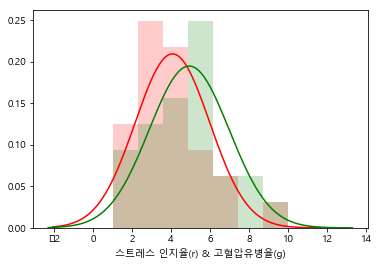

In [18]:

sns.distplot(report_score['스트레스 인지율'], kde=False, fit=stats.norm,
            hist_kws={'color': 'r', 'alpha': 0.2}, fit_kws={'color': 'r'})

sns.distplot(report_score['고혈압유병율'], kde=False, fit=stats.norm, 
             hist_kws={'color': 'g', 'alpha': 0.2}, fit_kws={'color': 'g'})
plt.xlabel('스트레스 인지율(r) & 고혈압유병율(g)')
result1

(0.2750502184219348, 0.18329435695551083)

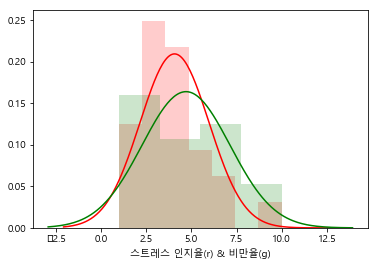

In [19]:
sns.distplot(report_score['스트레스 인지율'], kde=False, fit=stats.norm,
            hist_kws={'color': 'r', 'alpha': 0.2}, fit_kws={'color': 'r'})

sns.distplot(report_score['비만율'], kde=False, fit=stats.norm, 
             hist_kws={'color': 'g', 'alpha': 0.2}, fit_kws={'color': 'g'})
plt.xlabel('스트레스 인지율(r) & 비만율(g)')
result2

(0.42107866639731334, 0.036064585741783214)

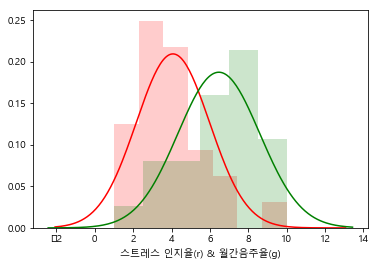

In [20]:
sns.distplot(report_score['스트레스 인지율'], kde=False, fit=stats.norm,
            hist_kws={'color': 'r', 'alpha': 0.2}, fit_kws={'color': 'r'})

sns.distplot(report_score['월간음주율'], kde=False, fit=stats.norm, 
             hist_kws={'color': 'g', 'alpha': 0.2}, fit_kws={'color': 'g'})
plt.xlabel('스트레스 인지율(r) & 월간음주율(g)')
result3

(-0.38601003763691966, 0.0566685031470028)

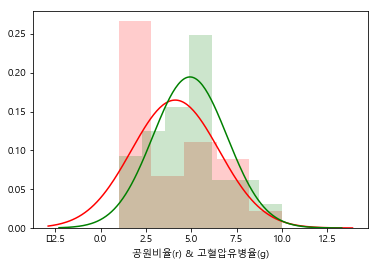

In [21]:
sns.distplot(report_score['공원비율'], kde=False, fit=stats.norm,
            hist_kws={'color': 'r', 'alpha': 0.2}, fit_kws={'color': 'r'})

sns.distplot(report_score['고혈압유병율'], kde=False, fit=stats.norm, 
             hist_kws={'color': 'g', 'alpha': 0.2}, fit_kws={'color': 'g'})
plt.xlabel('공원비율(r) & 고혈압유병율(g)')
result4

(-0.19372718880982873, 0.353471015809802)

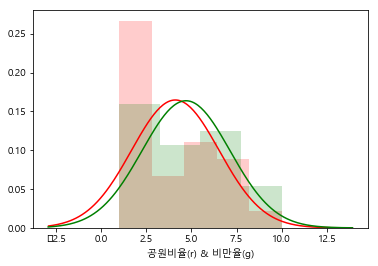

In [22]:
sns.distplot(report_score['공원비율'], kde=False, fit=stats.norm,
            hist_kws={'color': 'r', 'alpha': 0.2}, fit_kws={'color': 'r'})

sns.distplot(report_score['비만율'], kde=False, fit=stats.norm, 
            hist_kws={'color': 'g', 'alpha': 0.2}, fit_kws={'color': 'g'})
plt.xlabel('공원비율(r) & 비만율(g)')
result5

(0.4552782087485995, 0.022201804319440105)

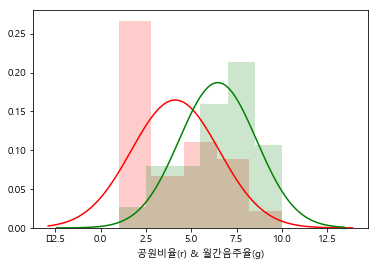

In [23]:
sns.distplot(report_score['공원비율'], kde=False, fit=stats.norm,
            hist_kws={'color': 'r', 'alpha': 0.2}, fit_kws={'color': 'r'})

sns.distplot(report_score['월간음주율'], kde=False, fit=stats.norm, 
             hist_kws={'color': 'g', 'alpha': 0.2}, fit_kws={'color': 'g'})
plt.xlabel('공원비율(r) & 월간음주율(g)')
result6

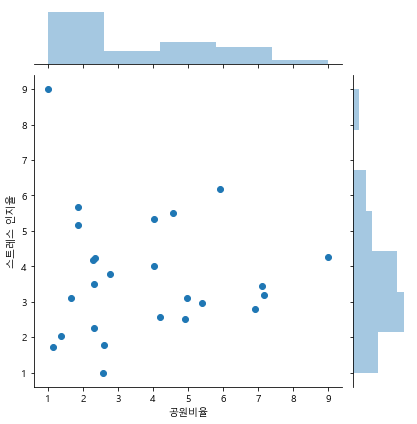

In [16]:
# 공원비율과 스트레스의 척도
sns.jointplot(x="공원비율", y="스트레스 인지율", data=report_score)

In [17]:
# 시각화 [서울시 구역별 공원]

geo_path = 'skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

park = pd.read_csv('parkseoul.csv')
park.head()

df_info = park[['지역', '공원명', '면적', 'X좌표(GRS80TM)', 'Y좌표(GRS80TM)', 'X좌표(WGS84)', 'Y좌표(WGS84)' ]].dropna(axis=0)

map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Toner')

map.choropleth(geo_data = geo_str,               
               data = report['공원비율'], 
               columns = [report.index, report['공원비율']],
               fill_color = 'PuRd',
               key_on = 'feature.properties.name')

df_info = park[['지역', '공원명', '면적', 'X좌표(GRS80TM)', 'Y좌표(GRS80TM)', 'X좌표(WGS84)', 'Y좌표(WGS84)' ]].dropna(axis=0)

for n in df_info.index:
    folium.CircleMarker([df_info['Y좌표(WGS84)'][n], df_info['X좌표(WGS84)'][n]], 
                         radius=df_info['면적'][n]*0.000005, # folium.Popup으로 공원명을 표시
                        color='#3186cc', fill=True, fill_color='#3186cc').add_to(map).add_child(folium.Popup(df_info['공원명'][n]))

map

In [133]:
# 3D 시각화 

# json 파일로 서울시의 지리 정보를 가져옴
geo_path = 'skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

# 입력될 변수
target = input('비교할 종목을 입력하세요 : ')

# json 파일과 취합한 자료를 결합
for i in range(len(report_score)) :  
    for j in range(len(report_score)) : 
        if geo_str['features'][i]['properties']["name"] == list(report_score.index)[j] :
            geo_str['features'][i]['properties'][target] = int(report_score[target][j])
            del geo_str['features'][i]['properties']['name_eng']
            del geo_str['features'][i]['properties']['code']
            del geo_str['features'][i]['properties']['base_year']   

# 시각화 하기
from mapboxgl.viz import *
from mapboxgl.utils import create_color_stops 
from mapboxgl.utils import create_numeric_stops
import mapboxgl

# https://www.mapbox.com/ 
# mapbox api key
token = 'pk.eyJ1IjoiY2F5b25kIiwiYSI6ImNrbXBxdDRidDJnczkyem56N3o5MDV6NXYifQ.ur9w4ggy--bMTHOk519RCQ'

# 서울시 중심부의 경도, 위도. 
center = [126.986, 37.565] 

# 시각화 할 값에 따른 색상의 범주를 지정.
# color_breaks 값 9가지 분류 가능
color_breaks = [17,20,23,26,29,32,35,38,41,44] 
color_stops = create_color_stops(color_breaks, colors='RdYlGn')

# mapping 
viz = ChoroplethViz(access_token=token, data=geo_str, color_property= target, color_stops=color_stops, center=center, zoom=10)

# 높낮이의 가시성을 위해 맵을 -15도 만큼 좌우 회전하고, 45도 만큼 상하 회전 
viz.bearing = -15
viz.pitch = 45
# 변수 target 을 기준으로 height 지정
viz.height_property = target
# 높이의 값을 변수 target에 따라 아래 간격으로 매핑
numeric_stops = create_numeric_stops([0,10,20,30,40,50,60,70,80,90,100], 0, 10000)

viz.height_stops = numeric_stops
viz.height_function_type = 'interpolate'
# 맵을 출력. 
viz.show()

비교할 종목을 입력하세요 : 총합


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")



script
소개
목차
  목표선정의 이유
  자료출처 및 수집과정
  자료의 점수화 및 P-VALUE
  변수의 상관관계 그래프
  서울시 공원 위치 #  폴리움
  서울시 구별 공원비율 # 3D
  서울시 구별 총점 # 막대그래프 & 3D
 결론
   지역대비 공원비율은 질병과 스트레스에 긍정적 영향을 미친다.
    
    
    
